In [1687]:
def main():
    path = r'C:\Users\Prabhat\Desktop\python progs'
    filename = "allegations_20200726939.csv"
    
    allegations_df = read_data(path, filename)
    eda_one(allegations_df)
    total_rows = eda_two(allegations_df)
    allegations_df_rank = numeric_rank(allegations_df)
    allegations_df_rank_board = numeric_board_disposition(allegations_df_rank)
    top_100_df, complaints_by_officer_df = complaints_by_officer(allegations_df_rank_board, total_rows)
    top_100_colour_df = apply_colour(top_100_df)
    create_bubble_chart(top_100_colour_df)    
    allegations_df_rank_time = calculate_time_for_decision(allegations_df_rank)
    create_time_histogram(allegations_df_rank_time)
    create_age_histogram(allegations_df)
    rank_vs_guilt_df = rank_vs_guilt(allegations_df_rank_time, complaints_by_officer_df)
    visualize_rank_changes(rank_vs_guilt_df)
    reason = 'Stop/Question/Frisk'
    offences_by_race(allegations_df, reason)
    allegation1 = 'Chokehold'
    allegation2 = 'Restricted Breathing'
    allegation_by_ethnicity(allegations_df, allegation1, allegation2)
    board_decision_race(allegations_df_rank_board)

In [1688]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from matplotlib.font_manager import FontProperties
import plotly
import numpy as np
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
pd.options.mode.chained_assignment = None
from plotly.graph_objs import *

Loading BokehJS ...

   unique_mos_id first_name last_name command_now  complaint_id  \
0          10004   Jonathan      Ruiz     078 PCT         42835   
1          10007       John     Sears     078 PCT         24601   
2          10007       John     Sears     078 PCT         24601   
3          10007       John     Sears     078 PCT         26146   
4          10009      Noemi    Sierra     078 PCT         40253   

   month_received  year_received  month_closed  year_closed  \
0               7           2019             5         2020   
1              11           2011             8         2012   
2              11           2011             8         2012   
3               7           2012             9         2013   
4               8           2018             2         2019   

  command_at_incident rank_abbrev_incident rank_abbrev_now        rank_now  \
0             078 PCT                  POM             POM  Police Officer   
1                PBBS                  POM             POM  Po

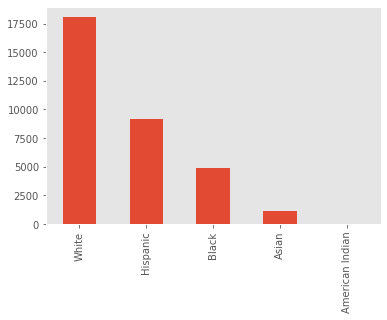

Dropping the 4464 NA values, about 59% of complaints are by Black people, 22% by Hispanic people and 9% by White people




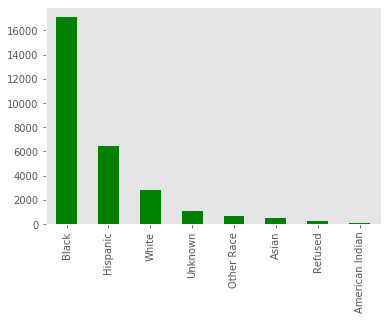

No arrest is made by the officer in 38% of cases




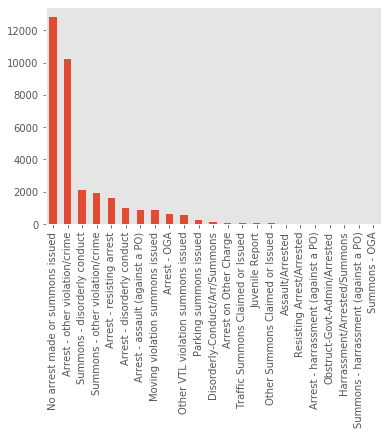

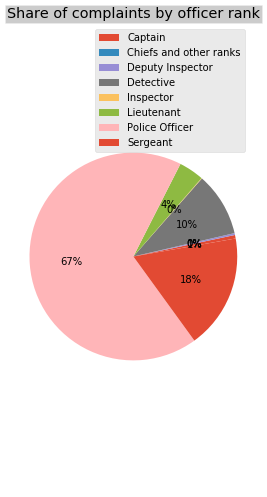

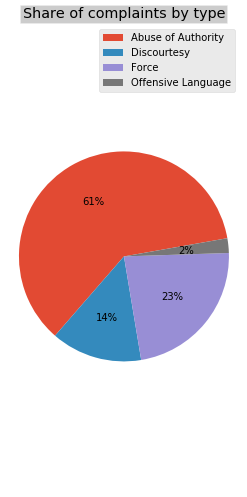

The board either exonerates or fails to substantiate complaint in 75% of cases




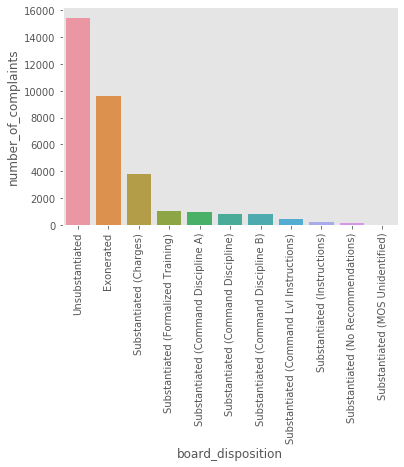

The 100 most errant officers - 2.5% of total - are responsible for 11% of total complaints


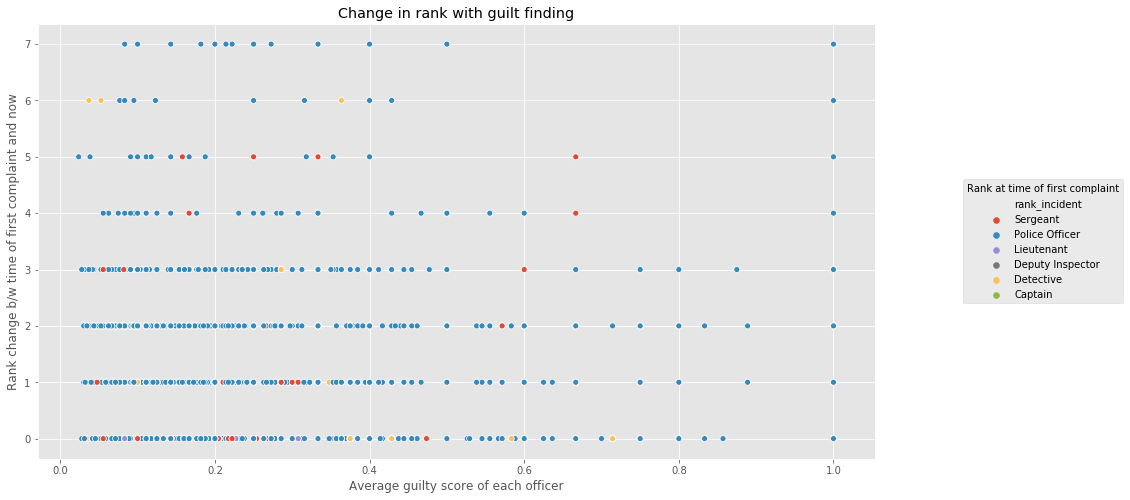

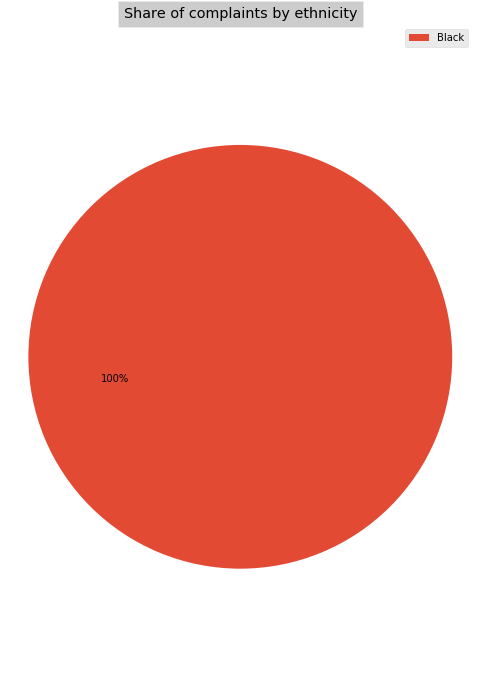

Dropping NaN, the total number of complaints against either chokehold or restricted breathing are 243


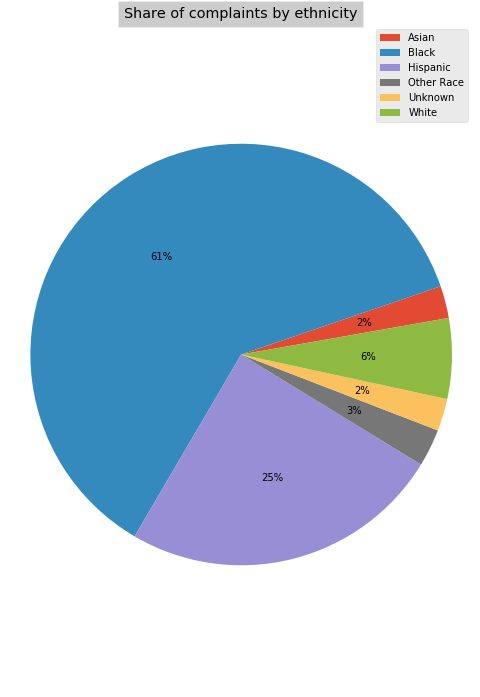

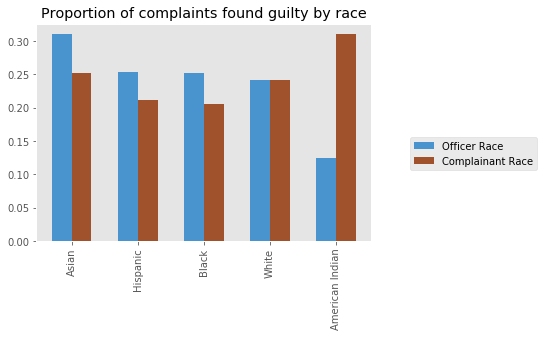

In [1689]:
from bokeh.io import output_file, output_notebook
from bokeh.plotting import figure, show
from bokeh.layouts import row, column, gridplot
from bokeh.models.widgets import Tabs, Panel
output_notebook()
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
import bokeh
from ipywidgets import interact, interact_manual
from bokeh.models import Legend, LegendItem
from numpy import pi
from bokeh.transform import cumsum
from bokeh.palettes import Spectral
from bokeh.palettes import RdBu3
from bokeh.palettes import Category20c
from bokeh.models import CategoricalColorMapper, HoverTool, ColumnDataSource
from bokeh.models import FactorRange

main()

In [1560]:
def read_data(path, filename):
    allegations_df = pd.read_csv(path + "\\" + filename)
    
    return allegations_df

## Part 1. Exploratory Data Analysis

In [1561]:
def eda_one(allegations_df):
    '''
    preliminary EDA
    '''
    
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(allegations_df.head())
    
    # columns to drop
    allegations_df = allegations_df.drop(['command_now', 'command_at_incident', 
                                          'rank_abbrev_incident', 'rank_abbrev_now', 'precinct'], axis = 1)
    # A total of 33358 complaints have been registered
    allegations_df.shape
    
    # the oldest complaint dates back to 1985, and the latest to 2020
    # the oldest complainant is 101 years old
    # there are some negative age values for complainants, which will be dealt with at an appropriate stage
    # the oldest officer to face a complaint is 60 years old, and the youngest 20
    allegations_df.describe()
    
    # check for NA
    allegations_df.isna().sum()
    
    
    print ("There are {} unique officers in the data set".format(allegations_df['unique_mos_id'].nunique()))
    print ("\n")
    print ("On average, each officer faces has over 8 complaints")

    print ("There are {} unique complaints in the data set".format(allegations_df['complaint_id'].nunique()))
    print ("\n")
    print ("On average, each complaint mentions nearly 3 separate offences (these offences could involve same or different officers)")

In [1672]:
def eda_two(allegations_df):
    '''
    slightly more advanced EDA
    '''

    total_rows = allegations_df.shape[0]
    print("About {}% of complaints are against White officers, {}% against Hispanic officers and {}% against Black officers".
      format(int(100*(allegations_df[allegations_df['mos_ethnicity'] == 'White'].shape[0])/total_rows), 
      int(100*(allegations_df[allegations_df['mos_ethnicity'] == 'Hispanic'].shape[0])/total_rows), 
      int(100*(allegations_df[allegations_df['mos_ethnicity'] == 'Black'].shape[0])/total_rows)))
    print("\n")

    ax1 = allegations_df['mos_ethnicity'].value_counts().plot(kind='bar')
    ax1.grid(False)
    plt.show()
    
    total_rows_wo_na = allegations_df[allegations_df['complainant_ethnicity'].notna()].shape[0]
    print("Dropping the 4464 NA values, about {}% of complaints are by Black people, {}% by Hispanic people and {}% by White people".
      format(int(100*(allegations_df[allegations_df['complainant_ethnicity'] == 'Black'].shape[0])/total_rows_wo_na), 
      int(100*(allegations_df[allegations_df['complainant_ethnicity'] == 'Hispanic'].shape[0])/total_rows_wo_na), 
      int(100*(allegations_df[allegations_df['complainant_ethnicity'] == 'White'].shape[0])/total_rows_wo_na)))
    print("\n")

    ax2 = allegations_df['complainant_ethnicity'].value_counts().plot(kind='bar', color = 'green')
    ax2.grid(False)
    plt.show()    
    print ("No arrest is made by the officer in {}% of cases".
           format(int(100*(allegations_df[allegations_df['outcome_description'] == 'No arrest made or summons issued'].
                           shape[0])/allegations_df.shape[0])))
    print("\n")
    
    ax3 = allegations_df['outcome_description'].value_counts().plot(kind='bar')
    ax3.grid(False)
    plt.show()
    
    # About 2/3 complaints were made against officers with the rank Police Officer, 18% against Sergeants
    by_off_rank_df = allegations_df.groupby('rank_incident').size().reset_index(name = 'number_of_complaints')

    ax4 = plt.subplot(121, aspect='equal')
    ax4.pie(by_off_rank_df['number_of_complaints'], autopct='%.0f%%',  startangle=10)
    ax4.axis('equal')
    plt.legend(labels = by_off_rank_df['rank_incident'], loc="best")
    plt.tight_layout()    
    plt.title("Share of complaints by officer rank", bbox={'facecolor':'0.8', 'pad':2})
    ax4 = plt.gcf()
    ax4.set_size_inches(7,7)
    plt.show()
    
    # FADO: Force, Abuse of Authority, Discourtesy, Offensive Language
    # 23% complaints involved alleged use of force by officers

    by_fado_df = allegations_df.groupby('fado_type').size().reset_index(name = 'number_of_complaints')

    ax5 = plt.subplot(121, aspect='equal')
    ax5.pie(by_fado_df['number_of_complaints'], autopct='%.0f%%',  startangle=10)
    ax5.axis('equal')
    plt.legend(labels = by_fado_df['fado_type'], loc="best")
    plt.tight_layout()    
    plt.title("Share of complaints by type", bbox={'facecolor':'0.8', 'pad':2})
    ax5 = plt.gcf()
    ax5.set_size_inches(7,7) 
    plt.show()
    
    print("The board either exonerates or fails to substantiate complaint in {}% of cases".
      format(int(100*(allegations_df[(allegations_df['board_disposition'] == 'Unsubstantiated') | 
                              (allegations_df['board_disposition'] == 'Exonerated')].shape[0])/allegations_df.shape[0])))
    print("\n")

    by_verdict_df = allegations_df.groupby('board_disposition').size().reset_index(name = 'number_of_complaints').sort_values('number_of_complaints', ascending = False)
    labels = list(by_verdict_df['board_disposition'].unique())
    ax6 = sns.barplot(x = 'board_disposition', y = 'number_of_complaints', data = by_verdict_df)
    ax6.set_xticklabels(rotation=90, labels = labels)
    ax6.grid(False) 
    plt.show()
    
    return total_rows

## Part 2. Do White cops disproportionately mistreat Black people?
##                        &
##         How likely are male cops to mistreat women?

#### This part tries to answer the above two questions through an interactive pie chart the end of this part

In [1670]:
def ethnicity_calculations(allegations_df):
    '''
    calculates distribution of complaints by complainants' race, for officers from different races
    '''
    
    # comp_ethnicity_df contains share of complaints by race of complainant for all officers (NaN values dropped)
    comp_ethnicity_df = allegations_df[allegations_df['complainant_ethnicity'].notna()].groupby('complainant_ethnicity').size().reset_index(name='total_complaints').sort_values('total_complaints', ascending = False)
    comp_ethnicity_df['percentage_of_overall_complaints'] = round(comp_ethnicity_df['total_complaints']*100/allegations_df[allegations_df['complainant_ethnicity'].notna()].shape[0],1)
    
    # off_ethnicity_df contains share of complaints by race of officer
    off_ethnicity_df = allegations_df[allegations_df['complainant_ethnicity'].notna()].groupby('mos_ethnicity').size().reset_index(name='number_of_complaints').sort_values('number_of_complaints', ascending = False)
    off_ethnicity_df['percentage_of_complaints'] = round(off_ethnicity_df['number_of_complaints']*100/allegations_df[allegations_df['complainant_ethnicity'].notna()].shape[0],1)
    
    # off_comp_ethnicity_df contains number of complaints by race of complainant, for each different race of officer
    off_comp_ethnicity_df = allegations_df.groupby(['complainant_ethnicity', 'mos_ethnicity']).size().reset_index(name='number_of_complaints')

    # merge_race_df merges the above two dataframes to calculate share of complaints by race of complainant, for each different race of officer
    merge_race_df = comp_ethnicity_df.merge(off_comp_ethnicity_df,on='complainant_ethnicity').merge(off_ethnicity_df,on='mos_ethnicity')
    merge_race_df['percentage_of_complaints'] = round(merge_race_df['number_of_complaints_x']*100/merge_race_df['number_of_complaints_y'],1)
    
    # retaining only the relevant columns
    merge_race_df = merge_race_df[['mos_ethnicity', 'complainant_ethnicity', 'percentage_of_complaints', 'percentage_of_overall_complaints']]
    
    return merge_race_df

In [1671]:
def gender_calculations(df):
    '''
    calculates distribution of complaints by complainants' gender, for officers from different genders
    based on a logic similar to the above function ethnicity_calculations
    '''
    
    comp_gender_df = allegations_df[allegations_df['complainant_gender'].notna()].groupby('complainant_gender').size().reset_index(name='total_complaints').sort_values('total_complaints', ascending = False)
    comp_gender_df['percentage_of_overall_complaints'] = round(comp_gender_df['total_complaints']*100/allegations_df[allegations_df['complainant_gender'].notna()].shape[0],1)
    
    off_comp_gender_df = allegations_df.groupby(['complainant_gender', 'mos_gender']).size().reset_index(name='number_of_complaints')
    off_gender_df = allegations_df[allegations_df['complainant_gender'].notna()].groupby('mos_gender').size().reset_index(name='number_of_complaints').sort_values('number_of_complaints', ascending = False)
    off_gender_df['percentage_of_complaints'] = round(off_gender_df['number_of_complaints']*100/allegations_df.shape[0],1)
    
    merge_gender_df = comp_gender_df.merge(off_comp_gender_df,on='complainant_gender').merge(off_gender_df,on='mos_gender')
    merge_gender_df['percentage_of_complaints'] = round(merge_gender_df['number_of_complaints_x']*100/merge_gender_df['number_of_complaints_y'],1)
    merge_gender_df = merge_gender_df[['mos_gender', 'complainant_gender', 'percentage_of_complaints', 'percentage_of_overall_complaints']]
    
    return merge_gender_df

In [1565]:
def race_pie_chart(race_of_accused, race_pie_chart_df):
    '''
    creates pie chart for racial distribution of complaints
    '''
    
    df_race = race_pie_chart_df.loc[race_pie_chart_df['mos_ethnicity'] == race_of_accused]
    df_race['angle'] = (df_race['percentage_of_complaints']*2*pi)/100
    df_race['color'] = Category20c[len(df_race)]    
    plot_race = figure(plot_height=350, 
                       title= "Race-wise proportion of victims when officer is {}".format(race_of_accused), 
                       toolbar_location=None, 
                       tools="hover", 
                       tooltips = "@complainant_ethnicity:@percentage_of_complaints")
    plot_race.wedge(x=0, y=1, radius=0.3, 
                    start_angle=cumsum('angle', include_zero=True), 
                    end_angle=cumsum('angle'), 
                    line_color="white", 
                    fill_color='color', 
                    source=df_race)    
    
    return plot_race

In [1566]:
def gender_pie_chart(gender_of_accused, gender_pie_chart_df):
    '''
    creates pie chart for gender-wise distribution of complaints
    '''
    
    c1 = RdBu3[2] # red
    c2 = RdBu3[0] # blue

    df_gender = gender_pie_chart_df.loc[gender_pie_chart_df['mos_gender'] == gender_of_accused]
    df_gender['angle'] = (df_gender['percentage_of_complaints']*2*pi)/100
    df_gender['color'] = Category20c[len(df_gender)]
    plot_gender = figure(plot_height=350, 
                         title= "Gender-wise proportion of victims when officer is {}".format(gender_of_accused), 
                         toolbar_location=None, 
                         tools="hover", 
                         tooltips = "@complainant_gender:@percentage_of_complaints")
    plot_gender.wedge(x=0, y=1, radius=0.4, start_angle=cumsum('angle', include_zero=True), 
                      end_angle=cumsum('angle'), 
                      line_color="white", 
                      fill_color='color',
                      source=df_gender)
    
    return plot_gender

#### The plot below is interactive; hover over it to see details and use tabs to switch b/w race and gender

In [1567]:
def combine_pie_charts(merge_race_df, merge_gender_df):
    '''
    combines race and gender pie charts into a single Bokeh plot
    '''
    
    races = list(merge_race_df.reset_index()['mos_ethnicity'].unique())
    genders = list(merge_gender_df.reset_index()['mos_gender'].unique())

    race_plots = [race_pie_chart(race, merge_race_df) for race in races]
    race_plots
    race_gridplot = gridplot([[race_plots[0], race_plots[1]],
                              [race_plots[2], race_plots[3]],
                              [race_plots[4], None]])
    race_panel = Panel(child = race_gridplot, title = 'Race-wise breakup of complaints')

    gender_plots = [gender_pie_chart(gender,merge_gender_df) for gender in genders]
    gender_gridplot = gridplot([[gender_plots[0], gender_plots[1], None]])
    gender_panel = Panel(child = gender_gridplot, title = 'Gender-wise breakup of complaints')

    tabs = Tabs(tabs=[race_panel, gender_panel])
    show(tabs)

## Part 3: Assign numerical values to officer ranks

##### Assigning numeric values to ranks will allow interesting analyses, as we will see later
##### I have assigned values to ranks in ascending order as per NYPD hierarchy (https://nypd.fandom.com/wiki/NYPD_Uniforms_and_Ranks)

##### Among the board findings (board_disposition) both Unsubstantiated and Exonerated have been assigned 0 
##### The several different forms of Substantiated findings - charges, command discipline etc. - have all been assigned 1

#### {'Police Officer': 0, 'Detective': 1, 'Sergeant': 2, 'Lieutenant': 3, 'Captain': 4, 'Deputy Inspector': 5, 'Inspector': 6, 'Chiefs and other ranks': 7}

In [1609]:
def numeric_rank(allegations_df):
    '''
    assigns numeric values to ranks at the time of complaint and at the current time, and calculates the difference
    b/w them
    '''
    # new column for numeric rank at the time of complaint
    allegations_df.loc[allegations_df['rank_incident'] == 'Police Officer', 'numeric_rank_incident'] = 0
    allegations_df.loc[allegations_df['rank_incident'] == 'Detective', 'numeric_rank_incident'] = 1
    allegations_df.loc[allegations_df['rank_incident'] == 'Sergeant', 'numeric_rank_incident'] = 2
    allegations_df.loc[allegations_df['rank_incident'] == 'Lieutenant', 'numeric_rank_incident'] = 3
    allegations_df.loc[allegations_df['rank_incident'] == 'Captain', 'numeric_rank_incident'] = 4
    allegations_df.loc[allegations_df['rank_incident'] == 'Deputy Inspector', 'numeric_rank_incident'] = 5
    allegations_df.loc[allegations_df['rank_incident'] == 'Inspector', 'numeric_rank_incident'] = 6
    allegations_df.loc[allegations_df['rank_incident'] == 'Chiefs and other ranks', 'numeric_rank_incident'] = 7
    
    # new column for numeric rank at the current time
    allegations_df.loc[allegations_df['rank_now'] == 'Police Officer', 'numeric_rank_now'] = 0
    allegations_df.loc[allegations_df['rank_now'] == 'Detective', 'numeric_rank_now'] = 1
    allegations_df.loc[allegations_df['rank_now'] == 'Sergeant', 'numeric_rank_now'] = 2
    allegations_df.loc[allegations_df['rank_now'] == 'Lieutenant', 'numeric_rank_now'] = 3
    allegations_df.loc[allegations_df['rank_now'] == 'Captain', 'numeric_rank_now'] = 4
    allegations_df.loc[allegations_df['rank_now'] == 'Deputy Inspector', 'numeric_rank_now'] = 5
    allegations_df.loc[allegations_df['rank_now'] == 'Inspector', 'numeric_rank_now'] = 6
    allegations_df.loc[allegations_df['rank_now'] == 'Chiefs and other ranks', 'numeric_rank_now'] = 7
    
    # new column to calculate difference in numeric ranks
    allegations_df['numeric_rank_change'] = allegations_df['numeric_rank_now'] - allegations_df['numeric_rank_incident']
    
    return allegations_df

## Part 4. Assign numerical values to findings of the disciplinary board (board_disposition)

##### Similar to ranks, assigning numeric values to board findings will allow interesting analyses
##### Among the board findings (board_disposition) both Unsubstantiated and Exonerated have been assigned 0 
##### The several different forms of Substantiated findings - charges, command discipline etc. - have all been assigned 1

In [1686]:
def numeric_board_disposition(allegations_df):
    '''
    makes a new column, board_finding, that creates one category for Unsubstantiated and Exonerated, and another for all 
    different forms of Substantiated; numeric_board_finding assigns 0 to Unsubstantiated/Exonerated category, and 1 to Substantiated category
    '''
    
    for idx, finding in enumerate(allegations_df.board_disposition.values):
        word = re.findall("^(Substantiated)", finding)
        if word == ['Substantiated']:
            allegations_df.loc[idx, 'board_finding'] = word
        else:
            allegations_df.loc[idx, 'board_finding'] = 'Unsubstantiated or exonerated'
    
    allegations_df.loc[allegations_df['board_finding'] == 'Unsubstantiated or exonerated', 'numeric_board_finding'] = 0
    allegations_df.loc[allegations_df['board_finding'] == 'Substantiated', 'numeric_board_finding'] = 1
    
    return allegations_df

## Part 5. Who are the most errant officers?

##### This part explores the 100 officers with most complaints against them
##### For each officer, parameters explored: total complaints, ethnicity, rank, no. of complaints in which found guilty

In [1685]:
def complaints_by_officer(allegations_df, total_rows):
    '''
    creates a dataframe, top_100_df, containing only the top 100 officers with most complaints
    '''
    # group by each unique officer to find his/her average guilty score
    # numeric_board_finding = 0 for Unsubstantiated or Exonerated, and 1 for Substantiated
    complaints_by_officer_df = allegations_df.groupby('unique_mos_id').agg({'unique_mos_id':'size', 'numeric_board_finding':'mean'}).rename(columns={'unique_mos_id':'number_of_complaints', 'numeric_board_finding':'avg_guilty_score'}).reset_index().sort_values('number_of_complaints', ascending=False)
    
    # create a new column, total_guilty_finding, to find the no. of complaints in which an officer has been found guilty
    complaints_by_officer_df['total_guilty_finding'] = complaints_by_officer_df['number_of_complaints']*complaints_by_officer_df['avg_guilty_score']
    
    # arrange by no. of complaints and drop duplicate IDs to reduce dataframe to the 3996 unique officers
    merge_complaints_df = pd.merge(complaints_by_officer_df, allegations_df, on = 'unique_mos_id')
    merge_complaints_df_sorted = merge_complaints_df.sort_values('number_of_complaints', ascending = False) 
    merge_complaints_df_sorted.drop_duplicates(keep='first',inplace=True, subset ="unique_mos_id")
    
    # the final dataframe
    top_100_df = merge_complaints_df_sorted.head(100)
    
    print("The 100 most errant officers - 2.5% of total - are responsible for {}% of total complaints".
          format(int(100*(top_100_df['number_of_complaints'].sum())/total_rows)))
       
    return top_100_df, complaints_by_officer_df

In [1627]:
def apply_colour(top_100_df):
    '''
    colour chart bubbles differently as per no. of complaints
    '''
    top_100_df.loc[top_100_df['number_of_complaints'] < 40, 'colour'] = 'green'
    top_100_df.loc[((top_100_df['number_of_complaints'] >= 40) & (top_100_df['number_of_complaints'] < 60)), 'colour'] = 'orange'
    top_100_df.loc[top_100_df['number_of_complaints'] >= 60, 'colour'] = 'red'
    
    return top_100_df

#### The plot below is interactive; hover over it to see details

In [1628]:
def create_bubble_chart(top_100_colour_df):
    cds = ColumnDataSource(top_100_colour_df)
    
    p_id = figure(plot_height = 650, plot_width = 1000, 
           title = 'The 100 officers with most complaints', x_axis_label = '',  y_axis_label = 'Number of Complaints')

    p_id.circle(x='unique_mos_id', y='number_of_complaints',
         source=cds,
         size=10, color='colour')

    hover = HoverTool(tooltips = [('First Name', '@first_name'),
                             ('Last Name', '@last_name'), ('Current Rank', '@rank_now'), 
                              ('Ethnicity', '@mos_ethnicity'), ('Complaints', '@number_of_complaints'),
                             ('Found guilty in', '@total_guilty_finding')])

    # Style the plot
    p_id.xaxis.major_tick_line_color = None
    p_id.xaxis.minor_tick_line_color = None
    p_id.xaxis.major_label_text_font_size = '0pt'  # turn off x-axis tick labels
    p_id.xgrid.grid_line_color = None
    p_id.ygrid.grid_line_color = None
    p_id.yaxis.axis_label_text_font_style = 'bold'
    p_id.title.align = 'center'
    p_id.title.text_font_size = '15pt'
    p_id.title.text_font = 'serif'

    # Add the hover tool to the graph
    p_id.add_tools(hover)

    show(p_id)

## Part 6. Does an officer's ethnicity decide how quickly (or slowly) the board reaches a decision?

#### The interactive histogram at the end of this part tells us that this isn't the case (hover over for details)
#### White officers vs. Black Officers

In [1681]:
def calculate_time_for_decision(allegations_df):
    '''
    creates a new column, months_to_close, to calculate the time taken by the board to reach a decision
    '''
    
    allegations_df['combine_r_year_month'] = allegations_df['year_received'].astype(str) + "-" + allegations_df['month_received'].astype(str)
    allegations_df['combine_c_year_month'] = allegations_df['year_closed'].astype(str) + "-" + allegations_df['month_closed'].astype(str)

    allegations_df['received_year_month'] = pd.to_datetime(allegations_df['combine_r_year_month'].astype(str), format='%Y-%m')
    allegations_df['closed_year_month'] = pd.to_datetime(allegations_df['combine_c_year_month'].astype(str), format='%Y-%m')

    allegations_df['months_to_close'] = round(((allegations_df['closed_year_month'] - allegations_df['received_year_month'])/np.timedelta64(1, 'M')),0)
    
    return allegations_df

In [1682]:
def create_time_histogram(allegations_df):
    '''
    creates a histogram for distribution of complaints by time taken (in months) to reach a decision
    drawing the histogram exclusively for officers of White and Black ethnicities produces similar results
    '''
    
    
    arr_hist, edges = np.histogram(allegations_df['months_to_close'], bins = 15,range = [0, 105])

    time_df = pd.DataFrame({'number_of_complaints': arr_hist, 
                       'left': edges[:-1], 
                       'right': edges[1:]})

    time_df['right'] = time_df['right'] - 1
    time_df['time_interval'] = ['%d to %d months' % (left, right) for left, right in zip(time_df['left'], (time_df['right']))]
    time_df['proportion_of_complaints'] = time_df['number_of_complaints']/time_df['number_of_complaints'].sum()
    
    src = ColumnDataSource(time_df)

    p_time = figure(plot_height = 600, plot_width = 600, 
           title = 'Distribution of time taken by board',
          x_axis_label = 'Months taken to reach decision', 
           y_axis_label = 'Number of Complaints')

    p_time.quad(source = src, bottom=0, top='number_of_complaints', left='left', right='right', 
       fill_color='red', line_color='black')

    hover = HoverTool(tooltips = [('Time Bracket (months)', '@time_interval'),
                             ('Proportion of complaints solved', '@proportion_of_complaints')])

    p_time.title.align = 'center'
    p_time.add_tools(hover)
    
    show(p_time)

## Part 7: Are the youth more likely to face police abuse?

#### The interactive histogram at the end of this part confirms this intuition (hover over for details)

In [1691]:
def create_age_histogram(allegations_df):
    '''
    creates a histogram for distribution of complaints by ages of complainants
    '''
    arr_hist, edges = np.histogram(allegations_df[allegations_df['complainant_age_incident'] > 0]['complainant_age_incident'], 
                               bins = 15, 
                               range = [0, 105])
    
    age_df = pd.DataFrame({'number_of_complaints': arr_hist, 
                       'left': edges[:-1], 
                       'right': edges[1:]})
    
    age_df['right'] = age_df['right'] - 1
    age_df['age_interval'] = ['%d to %d years' % (left, right) for left, right in zip(age_df['left'], (age_df['right']))]
    age_df['proportion_of_complaint'] = age_df['number_of_complaints']/age_df['number_of_complaints'].sum()
    
    src = ColumnDataSource(age_df)
    p = figure(plot_height = 600, plot_width = 600, 
           title = 'Histogram of age',
          x_axis_label = 'Age', 
           y_axis_label = 'Number of Complaints')

    p.quad(source = src, bottom=0, top='number_of_complaints', left='left', right='right', 
       fill_color='blue', line_color='black')

    hover = HoverTool(tooltips = [('Age Bracket', '@age_interval'),
                             ('Proportion of complaint', '@proportion_of_complaint')])

    p.add_tools(hover)
    show(p)

## Part 8. Visualize changes in ranks of each of the 3996 officers

### For the initial rank, an officer's rank at the time of the first complaint is chosen
### Due to this methodology, only the change in rank b/w the time of the first complaint and the current time is visible

In [1679]:
def visualize_rank_changes(rank_vs_guilt_df):
    '''
    visualizes changes in ranks of each of the 3996 officers through a sankey diagram (diagram renders outside notebook)
    rank_vs_guilt_df is taken from the function rank_vs_guilt, which is written right below this function
    '''
    # sankey_df produces numbers on changes between every pair of ranks, which are entered in links (below) to make the diagram 
    sankey_df = rank_vs_guilt_df.groupby(['rank_incident', 'rank_now']).size().reset_index(name = 'number_of_officers')

    
    nodes = [['ID', 'Label', 'Color'],
        [0,'Police Officer','#4994CE'],
        [1,'Detective','#8A5988'],
        [2,'Sergeant','#A0522D'],
        [3,'Lieutenant','#ffe873'],
        [4,'Captain','#646464'],
        [5,'Deputy Inspector','#449E9E'],
        [6,'Inspector',' #306998'],
        [7,'Chiefs and other ranks','#ffd43b'],
        [8,'Police Officer','#4994CE'],
        [9,'Detective','#8A5988'],
        [10,'Sergeant','#A0522D'],
        [11,'Lieutenant','#ffe873'],
        [12,'Captain','#646464'],
        [13,'Deputy Inspector','#449E9E'],
        [14,'Inspector',' #306998'],
        [15,'Chiefs and other ranks','#ffd43b'],]
    
    # the numbers for Value come from sankey_df
    links = [['Source','Target','Value','Link Color'],
         [0,8,1711,'rgba(145, 290, 7, 0.4)'],
         [0,9,931,'rgba(205, 150, 70, 0.4)'],
         [0,10,654,'rgba(127, 160, 180, 0.4)'],
         [0,11,222,'rgba(180, 200, 65, 0.6)'],
         [0,12,37,'rgba(127, 194, 65, 0.4)'],
         [0,13,22,'rgba(70, 94, 165, 0.4)'],
         [0,14,9,'rgba(10, 104, 165, 0.4)'],
         [0,15,17,'rgba(127, 194, 65, 0.4)'],
         
         [1,9,83,'rgba(127, 194, 65, 0.4)'],
         [1,10,16,'rgba(205, 150, 70, 0.4)'],
         [1,11,2,'rgba(127, 160, 180, 0.4)'],
         [1,12,1,'rgba(180, 200, 65, 0.6)'],
         [1,15,3,'rgba(127, 194, 65, 0.4)'],
        
         [2,10,143,'rgba(127, 194, 65, 0.4)'],
         [2,11,70,'rgba(205, 150, 70, 0.4)'],
         [2,12,17,'rgba(127, 160, 180, 0.4)'],
         [2,13,7,'rgba(180, 200, 65, 0.6)'],
         [2,14,4,'rgba(127, 194, 65, 0.4)'], 
         [2,15,4,'rgba(70, 94, 165, 0.4)'],
        
         [3,11,20,'rgba(127, 194, 65, 0.4)'],
         [3,12,7,'rgba(127, 194, 65, 0.4)'],
         [3,13,17,'rgba(127, 194, 65, 0.4)'],
         [3,14,7,'rgba(127, 194, 65, 0.4)'],
         [3,15,4,'rgba(127, 194, 65, 0.4)'], 
         
         [4,12,1,'rgba(127, 194, 65, 0.4)'],
         [4,14,2,'rgba(127, 194, 65, 0.4)'],
         [4,15,1,'rgba(127, 194, 65, 0.4)'],
         
         [5,13,2,'rgba(127, 194, 65, 0.4)'],
         
         [7,15,2,'rgba(127, 194, 65, 0.4)'],]
    
    
    nodes_headers = nodes.pop(0)
    links_headers = links.pop(0)
    df_nodes = pd.DataFrame(nodes, columns = nodes_headers)
    df_links = pd.DataFrame(links, columns = links_headers)
    
    data_trace = dict(
    type='sankey',
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 10,
    # thickness = 30,
      line = dict(
        color = "black",
        width = 0
      ),
      label =  df_nodes['Label'].dropna(axis=0, how='any'),
      color = df_nodes['Color']
    ),
    link = dict(
      source = df_links['Source'].dropna(axis=0, how='any'),
      target = df_links['Target'].dropna(axis=0, how='any'),
      value = df_links['Value'].dropna(axis=0, how='any'),
      color = df_links['Link Color'].dropna(axis=0, how='any'),
    )
    )

    layout = dict(
        title = "Change in rank of each officer from time of first complaint",
    height = 772,
    font = dict(
      size = 10),)

    fig = dict(data=[data_trace], layout=layout)
    plotly.offline.plot(fig, validate=False)

## Part 9: Does being found guilty of misconduct affect officers' promotion?

#### A scatter plot for each of the 3996 officers, of average guilty score vs. promotion, doesn't suggest so

#### Promotion is calculated as change in rank between the current rank and the rank at the time of first complaint

#### Average guilty score for an officer is the average of the number of times the board substantiates a complaint against the officer

In [1637]:
def rank_vs_guilt(allegations_df, complaints_by_officer_df):
    '''
    creates a dataframe, rank_vs_guilt_df, which has one entry for every officer as per the date of the first complaint
    against the officer
    '''
    
    # merging to get the 'received_year_month' column
    merge_df = pd.merge(allegations_df, complaints_by_officer_df, on = 'unique_mos_id')
    
    rank_vs_guilt_df = merge_df.sort_values('received_year_month', ascending = False)
    rank_vs_guilt_df.drop_duplicates(keep='last',inplace=True, subset ="unique_mos_id")
    
    # plot change in rank against average guilty score
    dims = (10,10)
    plt.figure(figsize=(15,8))
    ax = sns.scatterplot(x='avg_guilty_score', y='numeric_rank_change', hue = 'rank_incident',  data=rank_vs_guilt_df)
    ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), ncol=1, title='Rank at time of first complaint')
    ax.set(xlabel='Average guilty score of each officer', ylabel='Rank change b/w time of first complaint and now')
    ax.set_title("Change in rank with guilt finding")

    plt.show()
    
    return rank_vs_guilt_df

## Part 10: Are Black people singled out for certain offences?

#### Contrary to intuition, Black people don't have a particularly high share of complaints for offences such as parking violation
#### For Stop/Question/Frisk, 100% of complaints come from Black people, but this is from a sample of just 4 (the rest 202 are NaN)

In [1531]:
def offences_by_race(allegations_df, reason):
    '''
    plots a pie chart to show distribution of chosen offence (contact_reason) by race of complainants
    '''
    contact_by_ethnicity_df = allegations_df[(allegations_df['contact_reason'] == reason)].groupby('complainant_ethnicity').size().reset_index(name = 'number_of_complaints')
    
    ax = plt.subplot(121, aspect='equal')
    ax.pie(contact_by_ethnicity_df['number_of_complaints'], autopct='%.0f%%',  startangle=10, labeldistance=1.2)
    ax.axis('equal')
    plt.legend(labels = contact_by_ethnicity_df['complainant_ethnicity'], loc="best")
    plt.tight_layout()
    plt.title("Share of complaints by ethnicity", bbox={'facecolor':'0.8', 'pad':6})
    ax = plt.gcf()
    ax.set_size_inches(14,10)
    plt.show()

## Part 11: How often have cops been accused of chokehold/restricting breathing, and by which races?

#### Less than 1% complaints pertain to either chokehold or restricted breathing, and 61% of those are by Black People (similar to their overall share)

In [1690]:
def allegation_by_ethnicity(allegations_df, allegation1, allegation2):
    '''
    creates pie chart showing distribution of chokehold/restricted breathing by race
    '''
    
    allegation_by_ethnicity_df = allegations_df[(allegations_df['allegation'] == allegation1) | (allegations_df['allegation'] == allegation1)].groupby('complainant_ethnicity').size().reset_index(name = 'number_of_complaints')
    print ("Dropping NaN, the total number of complaints against either chokehold or restricted breathing are {}".format(allegation_by_ethnicity_df['number_of_complaints'].sum()))
    
    ax = plt.subplot(121, aspect='equal')
    ax.pie(allegation_by_ethnicity_df['number_of_complaints'], autopct='%.0f%%',  startangle=10, labeldistance=1.2)
    ax.axis('equal')
    plt.legend(labels = allegation_by_ethnicity_df['complainant_ethnicity'], loc="best")
    plt.tight_layout()    
    plt.title("Share of chokehold/restricted breathing by ethnicity", bbox={'facecolor':'0.8', 'pad':6})
    ax = plt.gcf()
    ax.set_size_inches(14,10)
    plt.show()

## Part 12: Does the board's decision depend on the race of the complainant and the officer?

#### The results are quite striking: American Indians, officers as well as complainants, enjoy a distinct advantage over other races.
#### The board is more likely to acquit American Indian officers, and determine guilt in complaints filed by American Indian complainants

In [1676]:
def board_decision_race(allegations_df):
    '''
    creates and merges dataframes containing average guilty scores (as calcultated in the function numeric_board_disposition) 
    by race of officer and complainant, and plots them
    '''
    
    # average guilty scores by race of officer 
    off_ethnicity_guilty_df = allegations_df.groupby('mos_ethnicity')['numeric_board_finding'].mean().reset_index(name = 'avg_guilty_score_off').sort_values('avg_guilty_score_off', ascending=False)
    
    # avrage guilty scores by race of complainant
    com_ethnicity_guilty_df = allegations_df.groupby('complainant_ethnicity')['numeric_board_finding'].mean().reset_index(name = 'avg_guilty_score_com')
    
    # merge the two to make a pie chart
    ethnicity_guilty_merge_df = pd.merge(off_ethnicity_guilty_df, com_ethnicity_guilty_df, left_on='mos_ethnicity', right_on='complainant_ethnicity', how = 'inner')
    
    # plot pie chart
    x = np.arange(5)
    w = 0.3
    ax1 = plt.subplot(1,1,1)
    plt.xticks(x + w /2, ethnicity_guilty_merge_df['mos_ethnicity'], rotation='vertical')
    plt.title("Proportion of complaints found guilty by race")
    officer = ax1.bar(x, ethnicity_guilty_merge_df['avg_guilty_score_off'], color='#4994CE', width=w, align='center')
    ax2 = ax1.twinx()
    complainant = ax2.bar(x + w, ethnicity_guilty_merge_df['avg_guilty_score_com'], color='#A0522D', width=w, align='center')
    plt.legend([officer, complainant], ['Officer Race', 'Complainant Race'], loc="best", bbox_to_anchor=(1.1, 0.5))
    ax1.grid(False)
    ax2.grid(False)
    ax2.set_yticks([10], minor = False)
    plt.show()